<a href="https://colab.research.google.com/github/Samuel-K95/iCog-PC-Task/blob/main/PC_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step by step breakdown of Predictive Coding.

1. Input Clamping

    - Fix the input layer to the data (e.g., an image or signal).
    - This is the “sensory input” that higher layers must explain.

2. Initialize Latent States

    - Randomly initialize hidden variables
    - These represent initial “guesses” about hidden causes of the input.

3. Top-Down Prediction

    - Each higher layer generates predictions for the layer below

4. Prediction Error Computation

    - For every layer, compute the mismatch:
    - These errors measure surprise or “unexplained” input.

5. Bottom-Up Error Propagation

    - Errors flow upwards in the hierarchy.

    - Lower-layer errors inform higher layers about how their predictions failed.

6. Inference: Update Latent States

    - Latent states are updated iteratively to reduce total error
    - This fast loop continues until the system “settles” (converges).

7. Recompute Predictions & Errors

    - After each latent update, recompute predictions and errors.

    - Repeat steps (3–6) for several iterations.

    - This ensures the network stabilizes into a consistent explanation of the input.

8. Weight Update (Learning)

    - Once inference converges, update generative weights
    - Local Hebbian-like rule: depends only on presynaptic activity and postsynaptic error.

9. Repeat for New Inputs

    - Restart the cycle with the next data sample (or minibatch).

    - Over time, weights adapt so predictions improve, reducing average error.

### Task

- Use the MNIST dataset to build a 4-layer predictive coding neural network for image classification.

- Train the network with Hebbian learning using Mean Squared Error (MSE) as the energy function.

- Run training for 5–10 epochs, measuring both loss and accuracy.

- Plot training vs validation loss curves (and accuracy curves) across epochs.

- Use TorchScript (torch.jit) for CPU-compatible parallelization and maintain progress with GitHub commit history.

In [20]:
# Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [21]:
# Constants

INPUT_DIM = 28 * 28
LAYER_DIMS = [INPUT_DIM, 512, 256, 128]
OUTPUT_DIM = 10

EPOCHS = 10
BATCH_SIZE = 256
NUM_WORKERS = 2
T_INFER = 50
ETA_INFER = 0.1
ETA_LEARN = 0.004
BETA_SUPERVISED = 0.2

DEVICE = "cpu"
print(f"Using device: {DEVICE}")

Using device: cpu


In [22]:
# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform = transform)
val_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [23]:
# Model Structure

class PredictieCodingNetwork(nn.Module):
  """
  An Object-Oriented container for the PCN weights.
  This class holds the learnable parameters in a structured way.
  The core computation is handled by external, JIT-compiled functions
  """

  def __init__(self, layer_dims, output_dim):
    super().__init__()
    self.layer_dims = layer_dims
    self.output_dim = output_dim
    self.L = len(layer_dims) - 1 # Number of latent layers

    # Create the generative layers (top-down predictions)
    # Stored from top to bottom: L3 -> L2, L2 -> L1, L1 -> Input
    self.generative_layers = nn.ModuleList()
    for i in range(self.L, 0, -1):
      # Layer predicts from dims[i] down to dims[i-1]
      self.generative_layers.append(nn.Linear(layer_dims[i], layer_dims[i-1], bias=False))

    # Readout layer for classification (predicts from top latent state)
    self.readout = nn.Linear(layer_dims[-1], output_dim, bias=False)


  def init_latents(self, batch_size):
    """
    Initializes latent states with random noise
    """

    latent_states = []
    for dim in self.layer_dims[1:]:
      state = torch.randn(batch_size, dim, device=DEVICE)
      latent_states.append(state)
    return latent_states

model = PredictieCodingNetwork(LAYER_DIMS, OUTPUT_DIM).to(device=DEVICE)
print("Model Architecture: \n", model)


Model Architecture: 
 PredictieCodingNetwork(
  (generative_layers): ModuleList(
    (0): Linear(in_features=128, out_features=256, bias=False)
    (1): Linear(in_features=256, out_features=512, bias=False)
    (2): Linear(in_features=512, out_features=784, bias=False)
  )
  (readout): Linear(in_features=128, out_features=10, bias=False)
)


In [24]:
# jit function for inference and learning

@torch.jit.script
def run_pcn_batch(
    x0: torch.Tensor,
    y_onehot: torch.Tensor,
    weights_gen: list[torch.Tensor],
    weight_readout: torch.Tensor,

    t_infer: int,
    eta_infer: float,
    eta_learn: float,
    beta_supervised: float,
    is_train: bool
):
  """
  JIT-compiled function to run a single batch through inference and learning.
  This uses explicit gradient updates.
  """

  batch_size = x0.shape[0]
  x1 = torch.randn(batch_size, weights_gen[2].shape[1], device=x0.device)
  x2 = torch.randn(batch_size, weights_gen[1].shape[1], device=x0.device)
  x3 = torch.randn(batch_size, weights_gen[0].shape[1], device=x0.device)

  # inference loop
  for _ in range(t_infer):
    xhat2 = F.relu(x3 @ weights_gen[0].t())
    xhat1 = F.relu(x2 @ weights_gen[1].t())
    xhat0 = F.relu(x1 @ weights_gen[2].t())

    # errors
    e2 = x2 - xhat2
    e1 = x1 - xhat1
    e0 = x0 - xhat0

    # calculate gradient for latents states
    # update rule is: dx/dt = -dE/dx ≈ ε_l - W_{l-1}^T @ (f'(a_{l-1}) ⊙ ε_{l-1})

    # Corrected linear operations
    grad_x1 = e1 - F.linear(e0 * (xhat0 > 0).float(), weights_gen[2].t())
    gradx2 = e2 - F.linear(e1 * (xhat1 > 0).float(), weights_gen[1].t())
    grad_x3 = -F.linear(e2 * (xhat2 > 0).float(), weights_gen[0].t())


    if is_train:
      y_hat = x3 @ weight_readout.t()
      e_sup = y_onehot - y_hat

      # Supervised signal pulls the top layer's representation
      grad_x3 -= F.linear(e_sup, weight_readout.t()) * beta_supervised


    # Update latent states via gradient descent

    x1 = x1 - eta_infer * grad_x1
    x2 = x2 - eta_infer * gradx2
    x3 = x3 - eta_infer * grad_x3


  final_y_hat = x3 @ weight_readout.t()
  final_val_loss = F.mse_loss(final_y_hat, y_onehot)

  if is_train:
    xhat2 = F.relu(x3 @ weights_gen[0].t())
    xhat1 = F.relu(x2 @ weights_gen[1].t())
    xhat0 = F.relu(x1 @ weights_gen[2].t())

    e2 = x2 - xhat2
    e1 = x1 - xhat1
    e0 = x0 - xhat0


    # Hebbian weight update, using W_l ∝ error_l * activation_{l+1}^T
    dw0 = torch.matmul((e2 * (xhat2 > 0).float()).t(), x3) / batch_size
    weights_gen[0] = weights_gen[0] + eta_learn * dw0

    dw1 = torch.matmul((e1 * (xhat1 > 0).float()).t(), x2) / batch_size
    weights_gen[1] = weights_gen[1] + eta_learn * dw1

    dw2 = torch.matmul((e0 * (xhat0 > 0).float()).t(), x1) / batch_size
    weights_gen[2] = weights_gen[2] + eta_learn * dw2


    e_sup = y_onehot - final_y_hat
    dw_readout = torch.matmul(e_sup.t(), x3) / batch_size
    weight_readout = weight_readout + eta_learn * dw_readout

  return weights_gen, weight_readout, final_val_loss, final_y_hat

In [25]:
# Training Loop

def run_epoch(model, loader, is_train):
  """
  A simple wrapper functtion to iterate over the data loader and call the
  JIT-compiled batch processing function
  """

  total_loss = 0.0
  correct_preds = 0
  total_samples = 0

  for inputs, targets in tqdm(loader, desc="Training" if is_train else "Validation"):
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    y_onehot = F.one_hot(targets, num_classes=OUTPUT_DIM).float()

    weight_gen = [layer.weight for layer in model.generative_layers]
    weight_readout = model.readout.weight

    updated_weights_gen, updated_weight_readout, batch_loss, final_y_hat = run_pcn_batch(
        x0=inputs,
        y_onehot=y_onehot,
        weights_gen=weight_gen,
        weight_readout=weight_readout,
        t_infer = T_INFER,
        eta_infer=ETA_INFER,
        eta_learn=ETA_LEARN,
        beta_supervised=BETA_SUPERVISED,
        is_train=is_train
    )

    if is_train:
      with torch.no_grad():
        for i in range(len(model.generative_layers)):
          model.generative_layers[i].weight.copy_(updated_weights_gen[i])

        model.readout.weight.copy_(updated_weight_readout)

    total_loss += batch_loss.item() * inputs.shape[0]
    preds = torch.argmax(final_y_hat, dim=1)
    correct_preds += (preds == targets).sum().item()
    total_samples += inputs.shape[0]

  return total_loss / total_samples, correct_preds / total_samples


Starting training...


Validation: 100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Epoch 1/10 | Train Loss: 0.1900 | Val Loss: 0.1714 | Val Accuracy: 17.22%


Validation: 100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Epoch 2/10 | Train Loss: 0.1139 | Val Loss: 0.1038 | Val Accuracy: 32.03%


Validation: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Epoch 3/10 | Train Loss: 0.0861 | Val Loss: 0.0836 | Val Accuracy: 47.18%


Validation: 100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Epoch 4/10 | Train Loss: 0.0768 | Val Loss: 0.0774 | Val Accuracy: 55.17%


Validation: 100%|██████████| 40/40 [00:26<00:00,  1.53it/s]


Epoch 5/10 | Train Loss: 0.0732 | Val Loss: 0.0747 | Val Accuracy: 58.32%


Validation: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Epoch 6/10 | Train Loss: 0.0712 | Val Loss: 0.0732 | Val Accuracy: 60.22%


Validation: 100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Epoch 7/10 | Train Loss: 0.0702 | Val Loss: 0.0725 | Val Accuracy: 60.27%


Validation: 100%|██████████| 40/40 [00:25<00:00,  1.58it/s]


Epoch 8/10 | Train Loss: 0.0693 | Val Loss: 0.0719 | Val Accuracy: 61.03%


Validation: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s]


Epoch 9/10 | Train Loss: 0.0687 | Val Loss: 0.0713 | Val Accuracy: 60.67%


Validation: 100%|██████████| 40/40 [00:25<00:00,  1.60it/s]


Epoch 10/10 | Train Loss: 0.0681 | Val Loss: 0.0709 | Val Accuracy: 60.59%

Training finished in 1832.12 seconds.


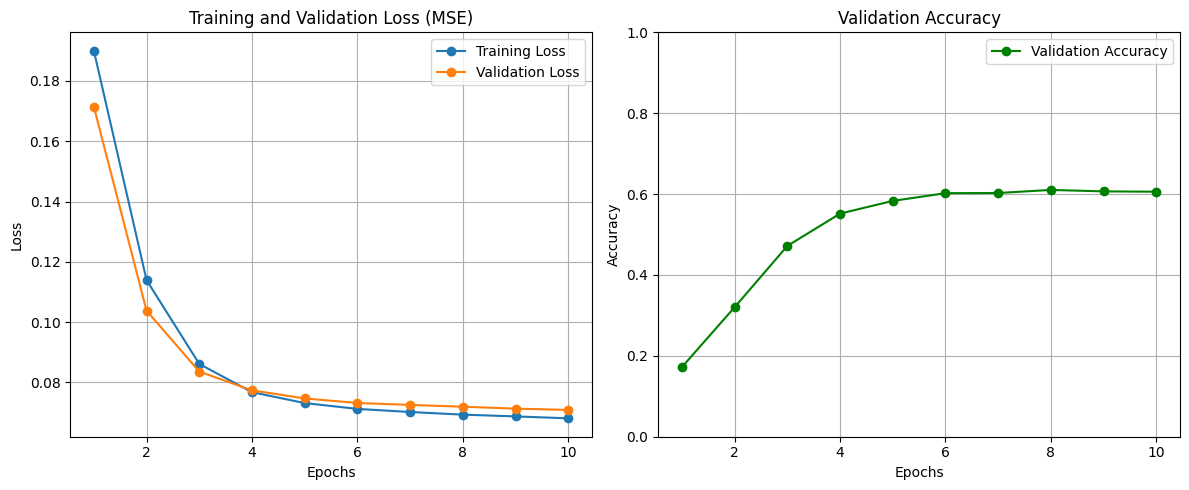

In [26]:
# Training loop
# --- MAIN TRAINING LOOP ---
train_losses, val_losses = [], []
val_accuracies = []

print("\nStarting training...")
start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    # The `no_grad` context is crucial as we do all updates manually
    with torch.no_grad():
      train_loss, _ = run_epoch(model, train_loader, is_train=True)

    model.eval()
    with torch.no_grad():
        val_loss, val_acc = run_epoch(model, val_loader, is_train=False)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Accuracy: {val_acc*100:.2f}%")

end_time = time.time()
print(f"\nTraining finished in {end_time - start_time:.2f} seconds.")


# --- VISUALIZATION ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, marker='o', label='Validation Loss')
plt.title('Training and Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), val_accuracies, marker='o', color='g', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()